Total number of tasks: 119, with 40 having finetuned BERT performance available.


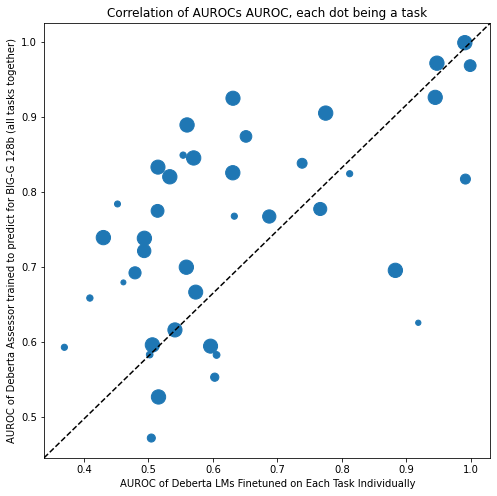

Between assessor and task-specific finetuning:
Pearson correlation: (0.5400487884573857, 0.0003221727934672249)
Spearman correlation: SpearmanrResult(correlation=0.5213883677298312, pvalue=0.0005607862163489554)
Between assessor and BIG-G:
Pearson correlation: (0.02194662026149019, 0.8930726438414617)
Spearman correlation: SpearmanrResult(correlation=0.0075046904315197, pvalue=0.9633426529961479)
Between task-specific finetuning and BIG-G:
Pearson correlation: (0.11863036318277909, 0.4659568034475622)
Spearman correlation: SpearmanrResult(correlation=-0.03114446529080676, pvalue=0.8487018985228155)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# TODO: Also see correlation between BIG-bench task performance and assessor performance

# Note: We have to make a choice here for task-system.
# The alternative is averaging, but let's not.
# TODO, can we also let it predict itself?
asss_df = pd.read_csv('../artifacts/csv-results/scaling-0sh-small/128b.csv')
asss_df.rename(columns={'Unnamed: 0': 'task'}, inplace=True)
task_df = pd.read_csv('../artifacts/csv-results/task-specific-finetuning/results-small.csv')
task_df = task_df[task_df['test_roc_auc'] != 0]
task_df = task_df[task_df['count'] > 20]
task_df.rename(columns={'Unnamed: 0': 'task'}, inplace=True)

print(f"Total number of tasks: {len(asss_df)}, with {len(task_df)} having finetuned BERT performance available.")

def correlation_plot(task_performance, asss_performance, metric: str, counts=None):
    plt.figure(figsize=(8, 8))
    # Set scatter size based on count
    if counts is not None:
        plt.scatter(task_performance, asss_performance, s=counts)
    else:
        plt.scatter(task_performance, asss_performance)
    plt.xlabel(f'{metric} of Deberta LMs Finetuned on Each Task Individually')
    plt.ylabel(f'{metric} of Deberta Assessor trained to predict for BIG-G 128b (all tasks together)')
    plt.title(f'Correlation of AUROCs {metric}, each dot being a task')

    # Minimum of both lists
    # min_val = min(min(task_performance), min(asss_performance))
    # plt.xlim(min_val - 0.1*min_val, 1)
    # plt.ylim(min_val - 0.1*min_val, 1)

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='k')
    plt.show()
    

filtered = asss_df.merge(task_df, on='task', suffixes=('_asss', '_task'))
assert len(filtered) == len(task_df)
assert (filtered.count_asss == filtered.count_task).all()
correlation_plot(
    filtered['test_roc_auc_task'],
    filtered['test_roc_auc_asss'],
    metric='AUROC',
    counts=filtered['count_task'] # Should be equal to filtered['count_asss']
)
# correlation_plot(filtered['test_accuracy_asss'], filtered['test_accuracy_task'], metric='accuracy')

# Pearson correlation
print(f"Between assessor and task-specific finetuning:")
print(f"Pearson correlation: {pearsonr(filtered['test_roc_auc_asss'], filtered['test_roc_auc_task'])}")
print(f"Spearman correlation: {spearmanr(filtered['test_roc_auc_asss'], filtered['test_roc_auc_task'])}")

# correlation_plot(
#     filtered['test_conf_normalized_roc_auc'], # BIG-G task performance
#     filtered['test_roc_auc_asss'],
#     metric='AUROC',
#     counts=filtered['count_task'] # Should be equal to filtered['count_asss']
# )

# Correlation between BIG-G and assessor
print(f"Between assessor and BIG-G:")
print(f"Pearson correlation: {pearsonr(filtered['test_roc_auc_asss'], filtered['test_conf_normalized_roc_auc'])}")
print(f"Spearman correlation: {spearmanr(filtered['test_roc_auc_asss'], filtered['test_conf_normalized_roc_auc'])}")

# Correlation between BIG-G and task-specific finetuning
print(f"Between task-specific finetuning and BIG-G:")
print(f"Pearson correlation: {pearsonr(filtered['test_roc_auc_task'], filtered['test_conf_normalized_roc_auc'])}")
print(f"Spearman correlation: {spearmanr(filtered['test_roc_auc_task'], filtered['test_conf_normalized_roc_auc'])}")